In [102]:
from imu_dataset import IMUDataset
from model import IMUModel
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.transforms as transforms
from pathlib import Path

In [103]:
DATASET_PATH = "../data_acquisition/dataset"
TRAIN_VALID_SPLIT = 0.8
DEVICE = torch.device("cpu")
BATCH_SIZE = 32
EPOCHS = 30
VERSION = 'v1'

In [104]:
def show_sample(sample, label):
    sample = sample.squeeze(0)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(IMUDataset.IDX_TO_CLASS[label], fontsize=16)
    axs[0].set_title("Accelerometer")
    axs[0].plot(sample[:, 0], label="x")
    axs[0].plot(sample[:, 1], label="y")
    axs[0].plot(sample[:, 2], label="z")
    axs[0].legend()
    axs[1].set_title("Gyroscope")
    axs[1].plot(sample[:, 3], label="x")
    axs[1].plot(sample[:, 4], label="y")
    axs[1].plot(sample[:, 5], label="z")
    axs[1].legend()
    plt.show()

In [105]:
def predict(model, tensor):
    tensor.to(DEVICE)
    model.to(DEVICE)

    model.eval()
    with torch.no_grad():
        start_time = time.time()
        output = model(tensor)
        ps = torch.exp(output)

        prob, idx = torch.max(ps, 1) # dim 0 is batch, dim 1 is probability distribution
        
        idx = idx[0].item() # item 0 of the batch
        prob = prob[0].item() # item 0 of the batch

        return IMUDataset.IDX_TO_CLASS[idx], prob, time.time() - start_time

In [106]:
input_transform = None #transforms.Normalize(...)

In [107]:
dataset = IMUDataset(base_path=DATASET_PATH, transform=input_transform)

train_set_size = int(len(dataset) * TRAIN_VALID_SPLIT)
valid_set_size = len(dataset) - train_set_size

train_dataset, valid_dataset = random_split(dataset, [train_set_size, valid_set_size])

len(train_dataset), len(valid_dataset)

(24, 6)

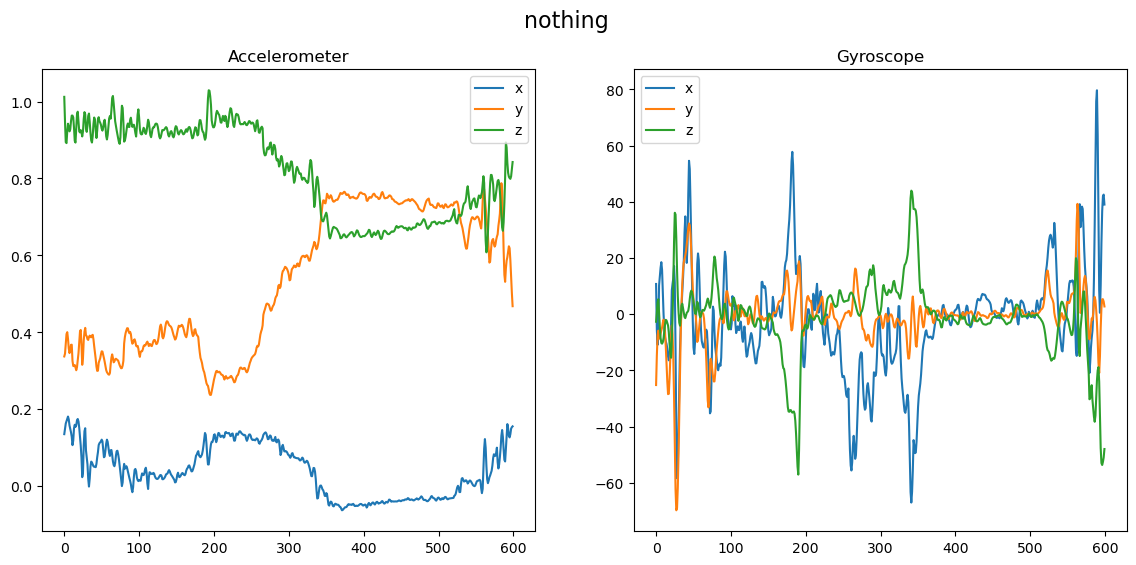

In [108]:
show_sample(*dataset[25])

In [109]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_data_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [110]:
model = IMUModel()
model = model.to(DEVICE)

In [111]:
loss = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

Epoch: 1/30
Training batch number: 000| Loss: 1.1072, Accuracy: 0.2917
Validation Batch number: 000| Loss: 1.2473, Accuracy: 0.0000
Epoch: 001| Train loss: 1.1072, Train accuracy: 29.1667% | Valid loss : 1.2473, Valid accuracy: 0.0000%| Time: 2.4738s
Epoch: 2/30
Training batch number: 000| Loss: 0.8045, Accuracy: 0.6667
Validation Batch number: 000| Loss: 1.1239, Accuracy: 0.1667
Epoch: 002| Train loss: 0.8045, Train accuracy: 66.6667% | Valid loss : 1.1239, Valid accuracy: 16.6667%| Time: 2.4504s
Epoch: 3/30
Training batch number: 000| Loss: 0.6319, Accuracy: 0.6667
Validation Batch number: 000| Loss: 1.0076, Accuracy: 0.3333
Epoch: 003| Train loss: 0.6319, Train accuracy: 66.6667% | Valid loss : 1.0076, Valid accuracy: 33.3333%| Time: 2.7646s
Epoch: 4/30
Training batch number: 000| Loss: 0.5338, Accuracy: 0.8333
Validation Batch number: 000| Loss: 0.8972, Accuracy: 0.8333
Epoch: 004| Train loss: 0.5338, Train accuracy: 83.3333% | Valid loss : 0.8972, Valid accuracy: 83.3333%| Time: 2

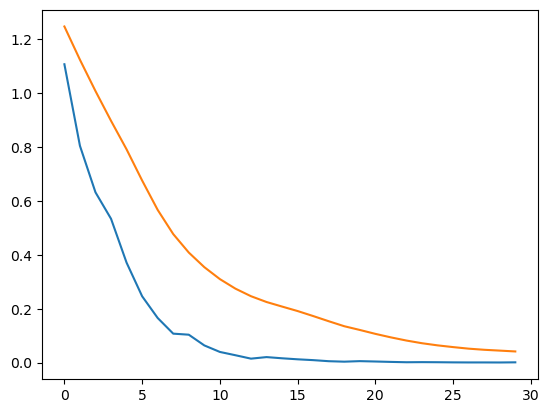

In [112]:
# training loop
history = []

for epoch in range(EPOCHS):
    epoch_start = time.time()
    
    print(f"Epoch: {epoch+1}/{EPOCHS}")
    
    # Set to training mode
    model.train()
    
    # Loss and Accuracy within the epoch
    train_loss = 0.0
    train_acc = 0.0
    valid_loss = 0.0
    valid_acc = 0.0
    
    for i, (inputs, labels) in enumerate(train_data_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # Clean existing gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss_value = loss(outputs, labels)

        # Backpropagate the gradients
        loss_value.backward()

        # Update the parameters
        optimizer.step()

        # Compute the total loss for the batch and add it to train_loss
        train_loss += loss_value.item() * inputs.size(0)

        # Compute the accuracy
        ret, predictions = torch.max(outputs.data, 1)
        correct_counts = predictions.eq(labels.data.view_as(predictions))
        
        # Convert correct_counts to float and then compute the mean
        acc = torch.mean(correct_counts.type(torch.FloatTensor))
        
        # Compute total accuracy in the whole batch and add to train_acc
        train_acc += acc.item() * inputs.size(0)
        print(f"Training batch number: {i:03d}| Loss: {loss_value.item():.4f}, Accuracy: {acc.item():.4f}")

    # Validation - No gradient tracking needed
    with torch.no_grad():
    
        # Set to evaluation mode
        model.eval()
    
        for j, (inputs, labels) in enumerate(valid_data_loader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss_value = loss(outputs, labels)

            # Compute the total loss for the batch and add it valid_loss
            valid_loss += loss_value.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
                
            # Compute total accuracy in the whole batch and add to valid_acc
            valid_acc += acc.item() * inputs.size(0)
            print(f"Validation Batch number: {j:03d}| Loss: {loss_value.item():.4f}, Accuracy: {acc.item():.4f}")
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/len(train_dataset) 
        avg_train_acc = train_acc/float(len(train_dataset))
        
        # Find average valid loss and valid accuracy
        avg_valid_loss = valid_loss/len(valid_dataset) 
        avg_valid_acc = valid_acc/float(len(valid_dataset))
        
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
        epoch_end = time.time()
        
        print("Epoch: {:03d}| Train loss: {:.4f}, Train accuracy: {:.4f}% | Valid loss : {:.4f}, Valid accuracy: {:.4f}%| Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

plt.plot([h[0] for h in history], label='train acc')
plt.plot([h[1] for h in history], label='valid acc')
plt.show()

In [113]:
# exporting
base_dir = Path(f"model_{VERSION}")
base_dir.mkdir(exist_ok=True)

# save compiled model
torch.jit.save(torch.jit.script(model), base_dir / f"model_{VERSION}.pt")

# save onnx model
torch.onnx.export(model.cpu(),
                  dataset[0][0].to('cpu').unsqueeze(0), # dummy input
                  base_dir / f"model_{VERSION}.onnx",
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'},    # batch is dynamic
                                'output' : {0 : 'batch_size'}}) 

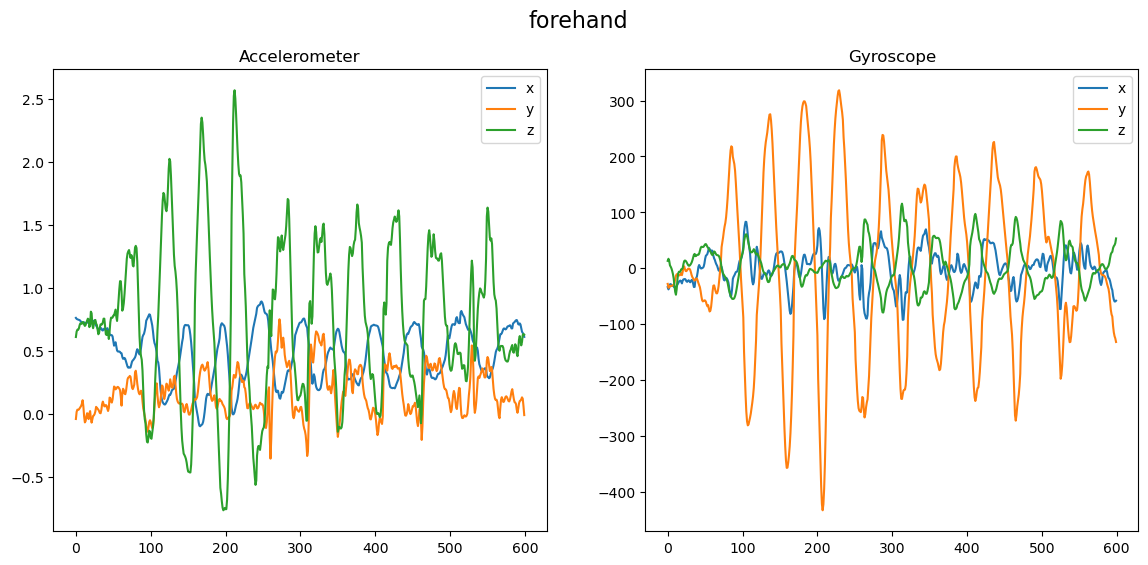

Predicted: forehand(99.9%), inference time: 15.84ms


In [120]:
# test prediction
sample = dataset[9]
tensor = sample[0].to('cpu').unsqueeze(0)
show_sample(*sample)

prediction, prob, inf_time = predict(model, tensor)
print(f"Predicted: {prediction}({prob*100:.1f}%), inference time: {inf_time*1000:.2f}ms")
